In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [231]:
bitcoin_data_df = pd.read_csv('bitcoin_final_data_2.csv',index_col=0)

In [232]:
bitcoin_roll_price_df = pd.read_csv('rolling_mean_prc.csv',index_col=0)

In [233]:
final_df = pd.merge(bitcoin_data_df,bitcoin_roll_price_df,how='inner',left_index=True,right_index=True)

In [234]:
final_df.tail()

,Open Price,Close Price,High Price,Low Price,Positive Count,Neutral Count,Negative Count,Total Count,Positive Percentage,Neutral Percentage,Negative Percentage,Search Interest,Roll Mean High Price
Date,,,,,,,,,,,,,
2018-03-07,10803.900391,9965.570313,10929.500000,9692.120117,7550,19300,1063,27913,27.048329,69.143410,3.808261,15.81,11345.114118
2018-03-08,9951.440430,9395.009766,10147.400391,9335.870117,1710,4650,229,6589,25.952345,70.572166,3.475489,14.62,11215.842773
2018-03-09,9414.690430,9337.549805,9466.349609,8513.030273,6933,18847,974,26754,25.913882,70.445541,3.640577,16.66,10969.749860
2018-03-10,9350.589844,8866.000000,9531.320313,8828.469727,6116,15344,819,22279,27.451860,68.872032,3.676108,11.90,10684.481306
2018-03-11,8852.780273,9578.629883,9711.889648,8607.120117,6060,14826,787,21673,27.961058,68.407696,3.631246,11.73,10427.237026


In [235]:
#final_df.drop(final_df.columns[[0,1,2,3,8,9,10,11]], axis=1, inplace=True)
#final_df.drop(final_df.columns[[0,1,2,3,4,5,6,8,9,10,11]], axis=1, inplace=True)
final_df = final_df[['Roll Mean High Price','Positive Count','Negative Count','Neutral Count','Search Interest']]

In [236]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [237]:
final_df.head()

,Roll Mean High Price,Positive Count,Negative Count,Neutral Count,Search Interest
Date,,,,,
2017-01-01,963.986851,1630,160,3410,2.64
2017-01-02,980.873422,2918,201,6669,4.86
2017-01-03,995.735134,3300,188,7648,4.44
2017-01-04,1021.949280,861,65,1981,4.98
2017-01-05,1052.192566,2554,218,5795,6.00


In [238]:
np.random.seed(7)

In [239]:
values = final_df.values
values = values.astype('float32')

In [240]:
scaler = RobustScaler()
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)

In [241]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,-0.291786,-0.657438,-0.471111,-0.889032,-0.368047,-0.289344,-0.091408,-0.349630,-0.363768,-0.105325
2,-0.289344,-0.091408,-0.349630,-0.363768,-0.105325,-0.287194,0.076467,-0.388148,-0.205980,-0.155030
3,-0.287194,0.076467,-0.388148,-0.205980,-0.155030,-0.283403,-0.995386,-0.752593,-1.119349,-0.091124
4,-0.283403,-0.995386,-0.752593,-1.119349,-0.091124,-0.279028,-0.251373,-0.299259,-0.504634,0.029586
5,-0.279028,-0.251373,-0.299259,-0.504634,0.029586,-0.277494,-0.019336,-0.216296,-0.048191,-0.126627


In [242]:
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)

In [243]:
values = reframed.values
n_train_days = 400
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [244]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [245]:
#train_X = train_X.reshape((train_X.shape[0],train_X.shape[1],1))
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[1],1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(400, 1, 5) (400,) (34, 1, 5) (34,)


In [246]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=100, batch_size=1, verbose=2)


#model = Sequential()
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=100, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
##plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='validation')
#plt.legend()
#plt.show()

Epoch 1/100
400/400 - 0s - loss: 0.2244
Epoch 2/100
400/400 - 1s - loss: 0.0240
Epoch 3/100
400/400 - 0s - loss: 0.0077
Epoch 4/100
400/400 - 1s - loss: 0.0033
Epoch 5/100
400/400 - 1s - loss: 0.0018
Epoch 6/100
400/400 - 1s - loss: 0.0016
Epoch 7/100
400/400 - 1s - loss: 0.0016
Epoch 8/100
400/400 - 1s - loss: 0.0011
Epoch 9/100
400/400 - 1s - loss: 0.0015
Epoch 10/100
400/400 - 1s - loss: 0.0010
Epoch 11/100
400/400 - 1s - loss: 9.9777e-04
Epoch 12/100
400/400 - 0s - loss: 0.0014
Epoch 13/100
400/400 - 1s - loss: 0.0012
Epoch 14/100
400/400 - 1s - loss: 0.0015
Epoch 15/100
400/400 - 1s - loss: 0.0010
Epoch 16/100
400/400 - 1s - loss: 0.0018
Epoch 17/100
400/400 - 1s - loss: 0.0014
Epoch 18/100
400/400 - 1s - loss: 0.0013
Epoch 19/100
400/400 - 1s - loss: 0.0013
Epoch 20/100
400/400 - 1s - loss: 0.0011
Epoch 21/100
400/400 - 0s - loss: 0.0013
Epoch 22/100
400/400 - 0s - loss: 9.8040e-04
Epoch 23/100
400/400 - 1s - loss: 0.0012
Epoch 24/100
400/400 - 1s - loss: 0.0010
Epoch 25/100
400/

In [247]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [248]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#print(inv_y)
#print(inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
error_percentage = mean_absolute_error(inv_y, inv_yhat)
mape = mape(inv_y,inv_yhat)
print('MAE : ',error_percentage)
print('MAPE : ',mape)

Test RMSE: 240.831
MAE :  159.0764
MAPE :  1.6146037727594376


In [249]:
inv_y

array([ 9256.263,  8988.765,  8741.617,  8683.717,  8639.688,  8537.012,
        8625.737,  8783.99 ,  8928.194,  9167.627,  9394.358,  9682.494,
       10073.02 , 10399.858, 10828.434, 11099.857, 11214.757, 11238.071,
       11160.6  , 10956.803, 10842.688, 10688.402, 10641.445, 10643.331,
       10743.574, 10876.574, 11103.629, 11279.214, 11368.014, 11345.114,
       11215.843, 10969.75 , 10684.481, 10427.237], dtype=float32)

In [250]:
inv_yhat

array([10077.35 ,  9649.682,  9061.432,  8854.662,  8712.59 ,  8688.864,
        8759.324,  8769.549,  8986.369,  9140.642,  9309.928,  9687.078,
        9990.213, 10319.746, 10564.443, 11100.023, 11290.595, 11148.461,
       11161.301, 11155.926, 11167.553, 10823.791, 10909.296, 10852.473,
       10770.572, 10887.748, 10899.549, 11277.171, 11352.611, 11367.362,
       11243.757, 11279.007, 10882.086, 10769.801], dtype=float32)

In [251]:
dt_df = final_df['Roll Mean High Price'].iloc[401:]

In [252]:
dt_df

Date
2018-02-06     9256.262835
2018-02-07     8988.764369
2018-02-08     8741.617187
2018-02-09     8683.717215
2018-02-10     8639.688616
2018-02-11     8537.011440
2018-02-12     8625.737165
2018-02-13     8783.989956
2018-02-14     8928.194197
2018-02-15     9167.627093
2018-02-16     9394.358399
2018-02-17     9682.494141
2018-02-18    10073.018415
2018-02-19    10399.858399
2018-02-20    10828.434152
2018-02-21    11099.857003
2018-02-22    11214.756975
2018-02-23    11238.071289
2018-02-24    11160.599888
2018-02-25    10956.802734
2018-02-26    10842.688477
2018-02-27    10688.402762
2018-02-28    10641.445592
2018-03-01    10643.331334
2018-03-02    10743.574219
2018-03-03    10876.574219
2018-03-04    11103.628488
2018-03-05    11279.214146
2018-03-06    11368.014090
2018-03-07    11345.114118
2018-03-08    11215.842773
2018-03-09    10969.749860
2018-03-10    10684.481306
2018-03-11    10427.237026
Name: Roll Mean High Price, dtype: float64

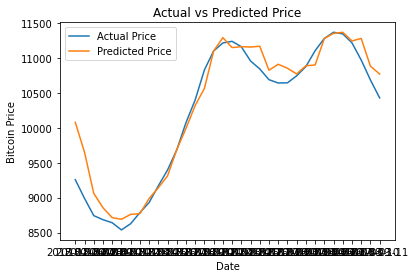

In [253]:
# line 1 points
x1 = dt_df.index #[10,20,30]
y1 = inv_y #[20,40,10]
# plotting the line 1 points 
plt.plot(x1, y1, label = "Actual Price")
# line 2 points
x2 = dt_df.index #[10,20,30]
y2 = inv_yhat #[40,10,30]
# plotting the line 2 points 
plt.plot(x2, y2, label = "Predicted Price")
plt.xlabel('Date')
# Set the y axis label of the current axis.
plt.ylabel('Bitcoin Price')
# Set a title of the current axes.
plt.title('Actual vs Predicted Price')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()